<meta name="twitter:card" content="summary_large_image">
<meta name="twitter:image" content="http://deeplearnphysics.org/Blog/imgs/2018-01-01-BrowsingSegmentationData_v0.1.0.thumbnail.png" />

Recently we added a new sample to our [public data](http://deeplearnphysics.org/DataChallenge) for **_semantic segmentation_** challenge. In this notebook I describe what this challenge is about and go over the sample contents. The goal is to make this sample Here's the outline.

0. [Semantic segmentation: what & how](#semantic_segmentation)
1. [Overall summary of sample generation configuration](#overview)
2. [Exploring file contents](#file_contents)
3. [Particle data product](#particle)
4. [Physics (particle kinematics, multiplicity, etc.)](#kinematics)
5. [Particle instance-wise pixel cluster (extra topic)](#cluster)

If you want to learn about this data set just in general, you may want to read all sections in this order. That should get you familiarized to start the main proposed challenge, **semantic segmentation** algorithm training. If you are looking into labels for <font color="red">_object detection algorithm training_</font>, you should check out section 3! If you are looking into labels for <font color="red">_instance-aware segmentation algorithm training_</font>, you should checkout section 5! 

... but before anything, let's start with basic package imports.

In [2]:
from __future__ import print_function
import ROOT
from ROOT import TChain
from larcv import larcv
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

We will use [test sample file](http://deeplearnphysics.org/DataChallenge/ChallengeSegmentation) to study the sample in this notebook.

<a name="semantic_segmentation"></a>
## Semantic Segmentation: what & how
In this challenge we train a machine learning algorithm to perform pixel-level image analysis. The task is to **classify every pixel in an image (i.e. <font color="blue">segmentation</font>) into one of pre-defined set of object classes (i.e. <font color="blue">semantics</font>) that the pixel represents.**. Unlike image classification, in which you only need to give one object label for the whole image, semantic segmentation algorithm can be used to identify multiple object types and locations at pixel level.  An output of an algorithm should look exactly like an input image (same size, same spatial resolution) except for the point that pixel values indicate an object category at each pixel. In this sample, there are only 3 pre-defined object categories: **shower** (_electromagnetic shower_ to be precise, electron or gamma ray), **track** (all other particles), and **background** (pixels without energy deposition from a particle).

So how can we train our algorithm? We can use _supervised training_ with labels provided in the sample. How to define _loss_ is up to us. One method is to use softmax (multinominal logistic loss) calculated per-pixel categorization and compute an average over all pixels.

**Enough texts!** If the above texts are confusing, I deeply apologize. Let's just visualize one example image of particles and the label (which is also an image). This might be a better way to explain actually :) 

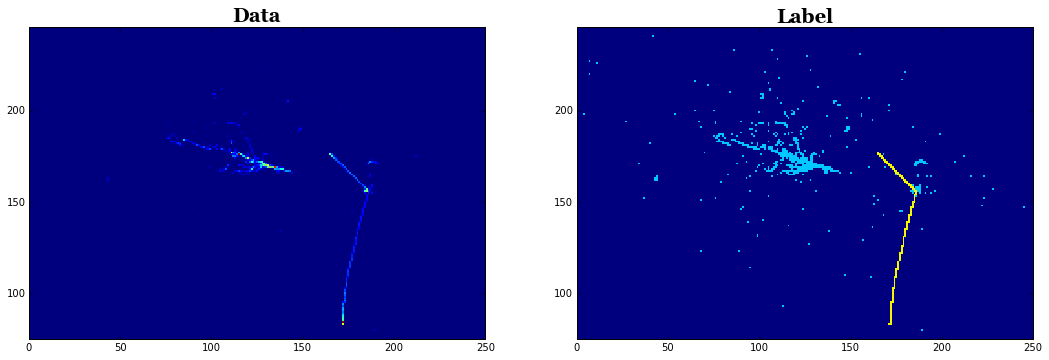

In [3]:
from larcv import larcv

# A utility function to compute the 2D (X,Y) range to zoom-in so that it avoids showing zero region of an image.
def get_view_range(image2d):
    nz_pixels=np.where(image2d>0.0)
    ylim = (np.min(nz_pixels[0])-5,np.max(nz_pixels[0])+5)
    xlim = (np.min(nz_pixels[1])-5,np.max(nz_pixels[1])+5)
    # Adjust for allowed image range
    ylim = (np.max((ylim[0],0)), np.min((ylim[1],image2d.shape[1]-1)))
    xlim = (np.max((xlim[0],0)), np.min((xlim[1],image2d.shape[0]-1)))
    return (xlim,ylim)

def show_event(entry=-1):
    # Create TChain for data image
    chain_image2d = ROOT.TChain('image2d_data_tree')
    chain_image2d.AddFile('test_10k.root')
    # Create TChain for label image
    chain_label2d = ROOT.TChain('image2d_segment_tree')
    chain_label2d.AddFile('test_10k.root')
    
    if entry < 0:
        entry = np.random.randint(0,chain_label2d.GetEntries())

    chain_label2d.GetEntry(entry)
    chain_image2d.GetEntry(entry)

    # Let's grab a specific projection (1st one)
    image2d = larcv.as_ndarray(chain_image2d.image2d_data_branch.as_vector().front())
    label2d = larcv.as_ndarray(chain_label2d.image2d_segment_branch.as_vector().front())

    # Get image range to focus
    xlim, ylim = get_view_range(image2d)
    
    # Dump images
    fig, (ax0,ax1) = plt.subplots(1, 2, figsize=(18,12), facecolor='w')
    ax0.imshow(image2d, interpolation='none', cmap='jet', origin='lower')
    ax1.imshow(label2d, interpolation='none', cmap='jet', origin='lower',vmin=0., vmax=3.1)
    ax0.set_title('Data',fontsize=20,fontname='Georgia',fontweight='bold')
    ax0.set_xlim(xlim)
    ax0.set_ylim(ylim)
    ax1.set_title('Label',fontsize=20,fontname='Georgia',fontweight='bold')
    ax1.set_xlim(xlim)
    ax1.set_ylim(ylim)
    plt.show()
    
    return (np.array(image2d), np.array(label2d))

# Let's look at one specific event entry
ENTRY = 2
image2d, label2d = show_event(ENTRY)

On the left, you find an image that contains multiple particles. The label image is shown on the right. To be pedantic, our task is to train an algorithm to output the right image from the left :) If you could not follow how I accessed image data from the file, you may want to read about "[Browsing Classification Data](http://deeplearnphysics.org/Blog/2017-12-29-BrowsingClassificationData_v0.1.0)" and/or follow more explicit list of [tutorials](http://deeplearnphysics.org/Blog/tutorial_summary.html).

The label image contains only 3 unique pixel values (0, 1, and 2) that indicate background (deep blue), shower (cyan), and track (yellow). I used an arbitrary color scale to make it easy to visualize. Let's just confirm there are really 3 unique pixel values in this image:

In [4]:
unique_values, unique_counts = np.unique(label2d, return_counts=True)
print('Label values:',unique_values)
print('Label counts:',unique_counts)

Label values: [ 0.  1.  2.]
Label counts: [64886   520   130]


Which means 64886 background, 520 shower, and 130 track pixels. 

OK, one more question before moving onto the next topic: <font color="red">**Is this label image good at pixel-level?**</font> If we are to use the right image as a label, it is better be correct at pixel-level. We can check the precision of object labels by using it as a mask to visualize three category of pixels in the input image.

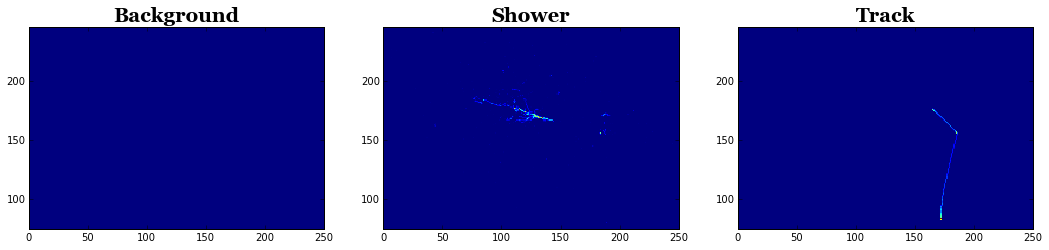

In [5]:
categories = ['Background','Shower','Track']

fig, axes = plt.subplots(1, len(unique_values), figsize=(18,12), facecolor='w')
xlim,ylim = get_view_range(image2d)
for index, value in enumerate(unique_values):
    ax = axes[index]
    mask = (label2d == value)
    ax.imshow(image2d * mask, interpolation='none', cmap='jet', origin='lower')
    ax.set_title(categories[index],fontsize=20,fontname='Georgia',fontweight='bold')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
plt.show()

... which looks pretty good!

### Pixels that are track _and_ shower?
By now you might have wondered "what about pixels where both track **and** shower particle deposit energy?" Very good point! Indeed that happens although the fraction to all none-background pixels is quite small. In this sample, we followed a convention that **such pixels are labeled as track.** In future, we plan to make a sample in which a pixel is allowed to have a _fractional_ categorization (i.e. X% track and Y% shower). One way to define such fraction could be the ratio of particle energy deposition from all contributing object categories. If you are interested in this sample and/or have a different suggestion, by all means [contact us](mailto:contact@deeplearnphysics.org)!

<a name="overview"></a>
## Conditions to make the samples
Below you find a list of conditions used to generate this sample. The goal was to make a good mixture of shower and track particles with a "reasonable" (not too boring) particle multiplicity per event, so that it suits training an algorithm for separating track and shower particle trajectories.

* The total particle multiplicity per event is set to be uniform between 2 to 5.
* A particle to be simulated is chosen from 4 categories with equal likelihood (25% chance per category). Isotropic momentum. Each category comes with a uniform kinetic energy (K.E.) distribution and allowed per-event multiplicity range shown below.
    * Category 0: light lepton (electron or muon) with K.E. range from 50 to 1000 MeV and multiplicity range from 0 to 3.
    * Category 1: gamma ray with K.E. range from 50 to 1000 MeV and multiplicity range from 0 to 2.
    * Category 2: charged pion (pion or anti-pion) with K.E. range from 50 to 1000 MeV and multiplicity range from 0 to 2.
    * Category 3: proton with K.E. range 50 to 400 MeV and multiplicity range from 0 to 3.
* All particles are generatd from a unique 3D point (i.e. _event vertex_). This position is uniformly distributed within the simulated volume over the events.
* A 3D sub-volume of 128 cm$^3$ is cropped and stored per event. The volume is defined to contain the event vertex and maximize the containment of particles' energy deposition in space. With these constraints, the cropping algorithm is free to randomize the 3D sub-volume position (to randomize event vertex position within the cropped sub-volume).
* Energy deposition for individual particle is stored in a 3D voxel of 0.5 cm$^3$ in MeV unit. This is projected onto three 2D planes: along x-y, y-z, and z-x axes. When stored in an image format, a scaling factor of 100 is applied for all pixel values.
* Events are filtered out if any of three 2D projection images have less than 5 pixels with pixel value >= 10 (which corresponds to 0.1 MeV prior to scaling). The minimum threshold of 10. is applied to all pixel values (i.e. a pixel with value below 10 is set to 0).

Note that, per event, shower (electron or gamma ray) vs. track particle multiplicity ratio is not quite the same. The category 0 has 50%-50% chance. But only 1 out of 3 other categories can generate a shower. So, multiplicity-wise, the sample slightly favors to generate more track particles. However, in terms of pixel counts per event, we may find more shower type pixels because shower particle trajectory tends to be more complicated and spread out in space. We will look at kinematics and multiplicity distributions in [later part](#kinematics) of this notebook. 

Visualizing some random contents of the files might help feeling more comfortable about types of events included in this sample. Here's 10 random event dump!

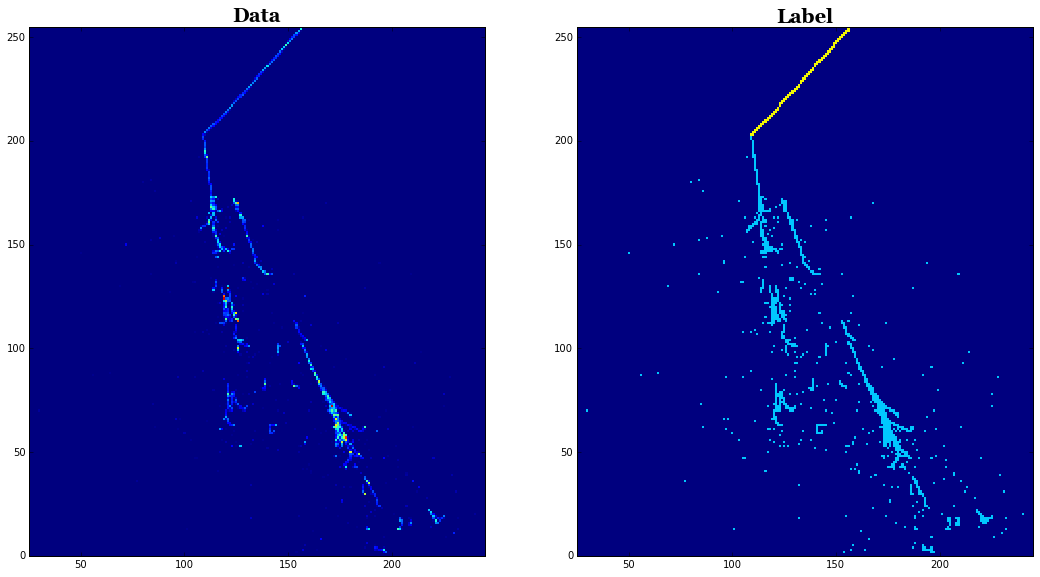

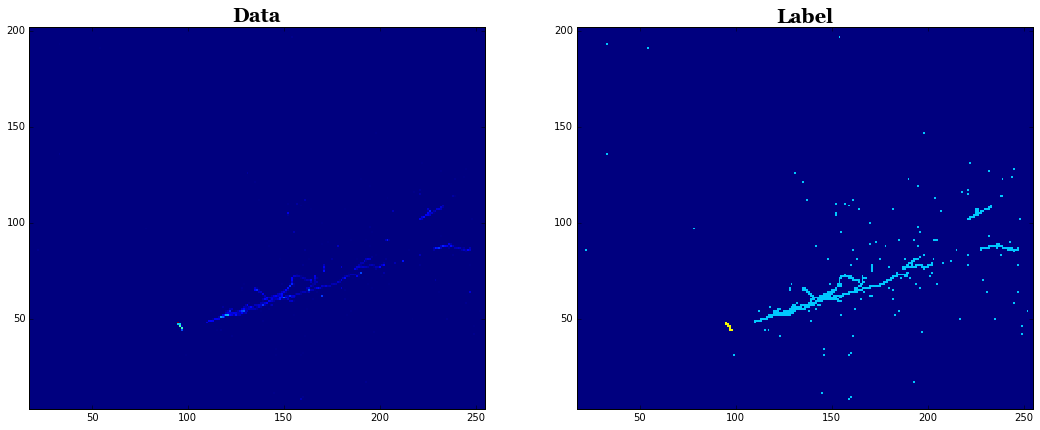

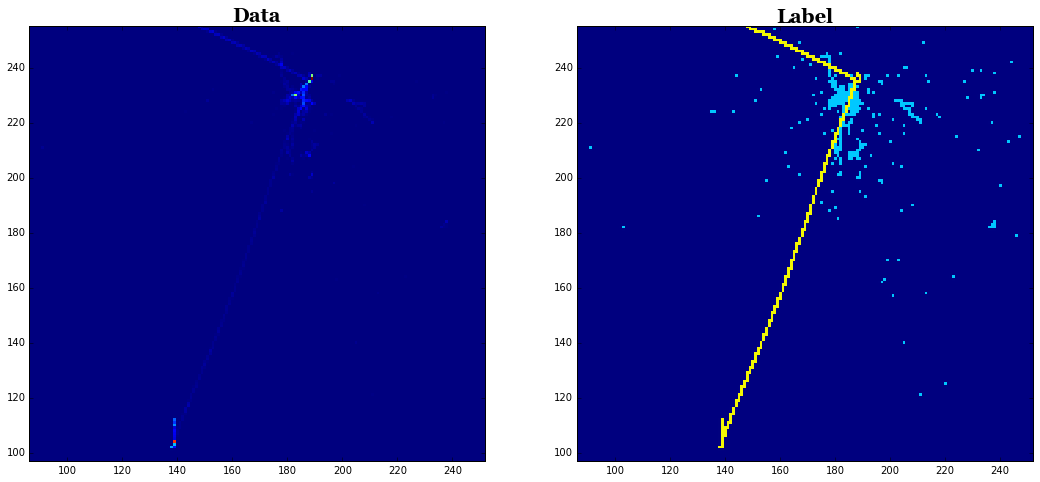

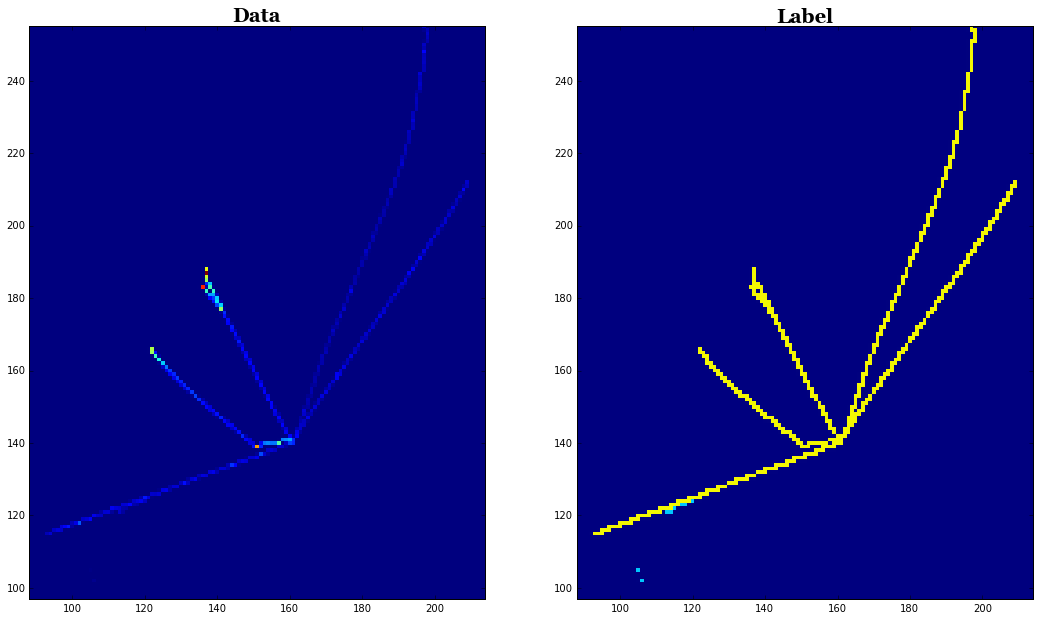

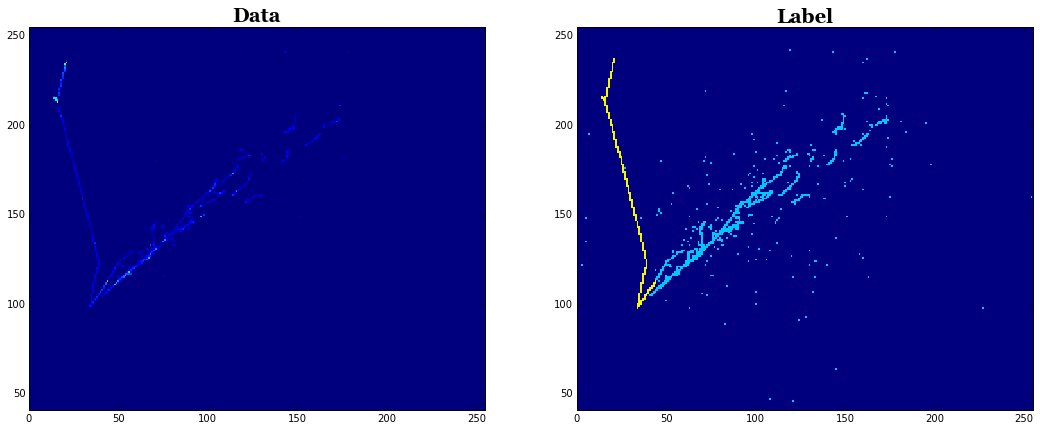

In [6]:
for _ in xrange(5): show_event()

<a name="file_contents"></a>
## Exploring the contents
Yeah, let's start by listing what data products we have in this file.

In [7]:
ROOT.TFile.Open('test_10k.root').ls()

TFile**		test_10k.root	
 TFile*		test_10k.root	
  KEY: TTree	cluster2d_mcst_tree;7	mcst tree
  KEY: TTree	cluster2d_mcst_tree;6	mcst tree
  KEY: TTree	image2d_data_tree;5	data tree
  KEY: TTree	image2d_data_tree;4	data tree
  KEY: TTree	image2d_segment_tree;3	segment tree
  KEY: TTree	image2d_segment_tree;2	segment tree
  KEY: TTree	particle_mcst_tree;1	mcst tree
  KEY: TTree	particle_mctruth_tree;1	mctruth tree


We already looked at <font color="blue">**image2d_data_tree**</font> and <font color="blue">**image2d_segment_tree**</font>: these are input data image to an algorithm and label (i.e. _answer_) to be used for supervised training. If you jumped to this section from the top, you can read [previous section](#semantic_segmentation) where we explored them briefly. Let me describe 3 more data products in the list below.

* <font color="blue">**particle_mctruth_tree**</font>
    * We already [covered this data product](http://deeplearnphysics.org/Blog/2017-12-29-BrowsingClassificationData_v0.1.0.html) in classification challenge sample. This is _particle_ (i.e. C++ `larcv::EventParticle`) data product which contains information about generated particles, called **primary particles**, that are injected into the simulation of a particle's trajectory in the detector medium (called _tracking simulation_). Note that, unlike a single-particle image classification dataset, we see more than one particle stored per event in this sample.
* <font color="blue">**particle_mcst_tree**</font>
    * This is also _particle_ data products but it stores the output of particle tracking simulation. As a result, it contains additional information such as deposited energy by a particle which forms a visible trajectory in an image, **secondary particles** that are created by interactions of the primary particles in the detector, and so on. 
* <font color="blue">**cluster2d_mcst_tree**</font>
    * This is _2D cluster_ data product (i.e. C++ `larcv::EventClusterVoxel2D`) that stores a cluster of pixels per particle instance. This data product is **not necessary to train semantic segmentation algorithm** (though can be useful), and is included for your algorithm R&D purpose beyond the challenge. **We will cover this data product at the [end of this notebook](#cluster)**.


<a name="particle"></a>
## Particle data product
Let's take a closer look at the difference between **particle_mctruth_tree** and **particle_mcst_tree**. We start with particle_mctruth_tree and will simply dump summary information about particles using a handy larcv::Particle::dump() function.

In [8]:
# Let's look at the same event we saw in the previous section
ENTRY=2

particle_mctruth_chain = TChain("particle_mctruth_tree")
particle_mctruth_chain.AddFile("test_10k.root")
particle_mctruth_chain.GetEntry(ENTRY)
cpp_object = particle_mctruth_chain.particle_mctruth_branch

print('particle_mctruth_tree contents:')
for particle in cpp_object.as_vector():
    print(particle.dump())

particle_mctruth_tree contents:
      Particle  (PdgCode,TrackID) = (2212,0) ... with Parent (2212,0)
      Vertex   (x, y, z, t) = (93.2396,78.1886,4.708,4105.05)
      Momentum (px, py, pz) = (-158.058,-575.546,515.5)
      Inittial Energy  = 1.2257
      Deposit  Energy  = 0
      Creation Process = primary
      BBox3D:     (0,0,0) => (0,0,0)

      Particle  (PdgCode,TrackID) = (2212,0) ... with Parent (2212,0)
      Vertex   (x, y, z, t) = (93.2396,78.1886,4.708,4105.05)
      Momentum (px, py, pz) = (-372.575,369.75,-173.048)
      Inittial Energy  = 1.08896
      Deposit  Energy  = 0
      Creation Process = primary
      BBox3D:     (0,0,0) => (0,0,0)

      Particle  (PdgCode,TrackID) = (22,0) ... with Parent (22,0)
      Vertex   (x, y, z, t) = (93.2396,78.1886,4.708,4105.05)
      Momentum (px, py, pz) = (-3.23032,-0.268878,91.3756)
      Inittial Energy  = 0.091433
      Deposit  Energy  = 0
      Creation Process = primary
      BBox3D:     (0,0,0) => (0,0,0)

      Parti

_Vertex_ (i.e. 3D position), _Momentum_, and _Initial Energy_ are the parameters of a particle at its creation. These are information that must be available when injecting a primary particle into the detector simulation. On the other hand, _Deposit Energy_, _TrackID_, and _BBox3D_ (3D axis-aligned bounding box defined by 2 diagonal points) are not filled. This is because particle_mctruth_tree holds information of primary particles after the generation but before the detector simulation. 

... <font color="red">**Note a bug:**</font> the _Initial Energy_ is in the unit of GeV while it should be in MeV!


Next, let's look at the same contents from particle_mcst_tree.

In [9]:
particle_mcst_chain = TChain("particle_mcst_tree")
particle_mcst_chain.AddFile("test_10k.root")
particle_mcst_chain.GetEntry(ENTRY)
cpp_object = particle_mcst_chain.particle_mcst_branch

print('particle_mcst_tree contents:')
for particle in cpp_object.as_vector():
    print(particle.dump())

particle_mcst_tree contents:
      Particle  (PdgCode,TrackID) = (2212,1) ... with Parent (2212,1)
      Vertex   (x, y, z, t) = (95.998,76.3177,4.65729,4105.05)
      Momentum (px, py, pz) = (-158.058,-575.546,515.5)
      Inittial Energy  = 1225.7
      Deposit  Energy  = 285.023
      Creation Process = primary
      BBox3D:     (85.75,41.75,4.75) => (93.25,78.25,35.25)
          Plane 0 BBox2D:     (85.75,41.75) => (93.25,78.25)
          Plane 1 BBox2D:     (41.75,4.75) => (78.25,35.25)
          Plane 2 BBox2D:     (4.75,85.75) => (35.25,93.25)

      Particle  (PdgCode,TrackID) = (2212,2) ... with Parent (2212,2)
      Vertex   (x, y, z, t) = (95.998,76.3177,4.65729,4105.05)
      Momentum (px, py, pz) = (-372.575,369.75,-173.048)
      Inittial Energy  = 1088.96
      Deposit  Energy  = 128.727
      Creation Process = primary
      BBox3D:     (82.75,78.25,0.25) => (93.25,88.75,4.75)
          Plane 0 BBox2D:     (82.75,78.25) => (93.25,88.75)
          Plane 1 BBox2D:     (78

Here, you see _Deposit Energy_ and _BBox3D_ are filled. Both information are only available after simulation of a particle's trajectory in the detector is finished. _BBox2D_ is a projection of _BBox3D_ onto 3 created 2D projection images. We also see _TrackID_ is now filled. This is a unique, positive integer per particle that can be used to identify a unique particle instance.

We used larcv::Particle::dump() function to be lazy and only see a part of information stored in this data product. There is a lot more to explore, and you can find all list by either looking at [C++ header file](https://github.com/DeepLearnPhysics/larcv2/blob/develop/larcv/core/DataFormat/Particle.h) or simply running python `help` function. It is worth mentioning that this data product also contains the parent particle information for the secondaries (and also the root primary particle, called _ancestor_) that created them. In the above text summary, you can see all particles' _TrackID_ is matching with its _Parent TrackID_. This is a unique feature of the primaries (i.e. they are registered as their own parents).


### What is _Deposit Energy_?
Note that _Initial Energy_ is a sum of a particle's mass and kinetic energy while _Deposit Energy_ is computed by collecting all granular energy depositions simulated per particle. So _Deposit Energy_ should be always smaller than _Initial Energy_, and the difference can not be smaller than the particle mass. Looking at TrackID 3 gamma ray, _Deposit Energy_ and _Initial Energy_ are quite close. This means this gamma ray, which has 0 mass, deposited almost all its energy in the image. On the other hand, TrackID 4 gamma ray has $\approx180$ MeV gap. It means this gamma ray has escaped the image region and some of its energy is not included in the image. _Deposit Energy_ can be useful to know how much energy of a particle actually contributed to make image features.

### Particle bounding-box
Finally let me demonstrate bounding-box variable. Let's use the same event and draw the stored bounding box on the same image we already visualized in the [previous section](#semantic_segmentation). This can tell us which _particle_ data product corresponds to which _particle_ we visually observe!

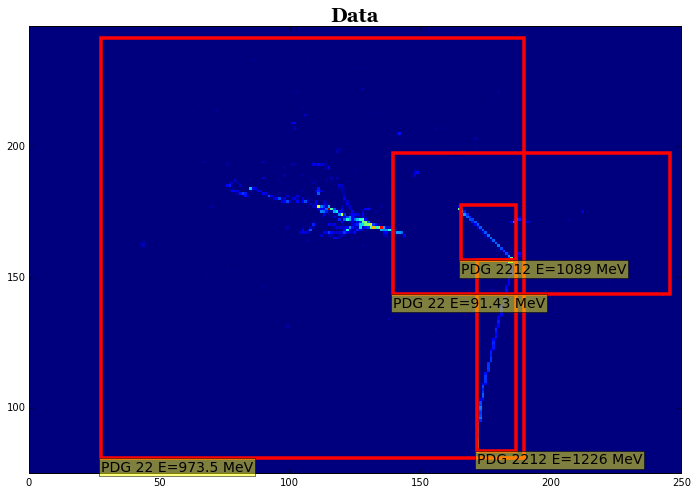

In [10]:
import matplotlib.patches as patches
ENTRY=2

#
# Draw an image first
#
# Create TChain for data image
chain_image2d = ROOT.TChain('image2d_data_tree')
chain_image2d.AddFile('test_10k.root')
chain_image2d.GetEntry(ENTRY)

# Let's grab a specific projection (1st one)
cpp_image2d = chain_image2d.image2d_data_branch.as_vector().front()
image2d = larcv.as_ndarray(cpp_image2d)
    
# Draw image
fig, ax = plt.subplots(figsize=(12,8), facecolor='w')
ax.imshow(image2d, interpolation='none', cmap='jet', origin='lower')
ax.set_title('Data',fontsize=20,fontname='Georgia',fontweight='bold')

#
# Draw bounding boxes
#
particle_mcst_chain = TChain("particle_mcst_tree")
particle_mcst_chain.AddFile("test_10k.root")
particle_mcst_chain.GetEntry(ENTRY)
cpp_object = particle_mcst_chain.particle_mcst_branch

for particle in cpp_object.as_vector():
    # obtain bounding-box: it's in [cm] scale 
    box = particle.boundingbox_2d().front()
    x_pixel_pos = box.min_x()  / cpp_image2d.meta().pixel_width()
    y_pixel_pos = box.min_y()  / cpp_image2d.meta().pixel_height()
    box_width   = box.width()  / cpp_image2d.meta().pixel_width()
    box_height  = box.height() / cpp_image2d.meta().pixel_height()

    ax.add_patch(plt.Rectangle( (x_pixel_pos, y_pixel_pos), box_width, box_height,
                                fill=False,
                                edgecolor='red', linewidth=3.5 )
                )
    
    ax.text(x_pixel_pos, y_pixel_pos - 5, 
            'PDG {:d} E={:.4g} MeV'.format(particle.pdg_code(),particle.energy_init()),
            bbox=dict(facecolor='yellow', alpha=0.5), fontsize=14, color='black'
           )
    
# Get image range to focus
xlim, ylim = get_view_range(image2d)
ax.set_xlim(xlim)
ax.set_ylim(ylim)

plt.show()

I hope you are now thinking "I can totally use this to train an object detection network" :) You are correct! [This paper](https://arxiv.org/abs/1611.05531) used a similar sample to train a convolutional neural network to find an interaction region in an event.

One last comment: can we do better than just bounding box? Can we know exactly which pixel corresponds to a particle instead of just a rectangular box? Can we know how much energy deposition in every pixel is made by each particle? <font color="blue">**The answer is yes**</font>, and that is what stored in **cluster2d_mcst_tree** and we will cover in the [later section](#cluster2). 

<a name="kinematics"></a>
## Physics distributions
We saw lots of pictures so far, so it's time to look at "plots" and exercise some quantification of physics parameters in the sample :) Let's take a look at several physics parameter distributions. We create `pandas` _DataFrame_ in this example analysis.

In [11]:
# Create TChain
particle_mcst_chain = TChain("particle_mcst_tree")
particle_mcst_chain.AddFile("test_10k.root")
num_entries = particle_mcst_chain.GetEntries()

# These are handy constants
PDG_LIST = np.array([11,22,13,211,-211,2212])
PDG_NAME = ['electron','gamma','muon','piplus','piminus','proton']

# These are analysis variable containers
total_deposit_energy  = np.zeros([num_entries],dtype=np.float32)
total_kinetic_energy  = np.zeros([num_entries],dtype=np.float32)
total_multiplicity    = np.zeros([num_entries],dtype=np.int32)
particle_multiplicity = [np.zeros([num_entries],dtype=np.int32) for _ in PDG_LIST]

# Event loop to fill the analysis variable containers
for entry in np.arange(num_entries):
    particle_mcst_chain.GetEntry(entry)
    cpp_object = particle_mcst_chain.particle_mcst_branch
    
    deposit_energy = 0.
    initial_energy = 0.
    multiplicity = 0
    for particle in cpp_object.as_vector():
        deposit_energy += particle.energy_deposit()
        if not particle.track_id() == particle.parent_track_id(): continue
        particle_multiplicity[np.where(particle.pdg_code() == PDG_LIST)[0][0]][entry] += 1
        multiplicity += 1
        initial_energy += (particle.energy_init() - larcv.ParticleMass(particle.pdg_code()))
        
    total_multiplicity[entry]   = multiplicity
    total_deposit_energy[entry] = deposit_energy
    total_kinetic_energy[entry] = initial_energy

import pandas as pd
df = pd.DataFrame(data={'initial_energy' : total_kinetic_energy,
                        'deposit_energy' : total_deposit_energy,
                        'multi_total'    : total_multiplicity,
                        'multi_electron' : particle_multiplicity[0],
                        'multi_gamma'    : particle_multiplicity[1],
                        'multi_muon'     : particle_multiplicity[2],
                        'multi_piplus'   : particle_multiplicity[3],
                        'multi_piminus'  : particle_multiplicity[4],
                        'multi_proton'   : particle_multiplicity[5]})

### Particle multiplicity 
Let's check out multiplicity distributions and see if they look like what we expect (see the [previous section](#overview) for the sample generation configuration). First, the total multiplicity per event should be flat from 2 to 5.

In [12]:
# Let's checkout multiplicity unique values & counts
unique_values, unique_counts = np.unique(df.multi_total, return_counts=True)
print()
print('Multiplicity values:',unique_values)
print('Multiplicity counts:',unique_counts)


Multiplicity values: [1 2 3 4 5]
Multiplicity counts: [  17 2545 2422 2552 2464]


... which confirms our expectation. How about particle-wise distribution? Let's compare electron, muon, and gamma ray. We expect electron and muon (from category 0 in [configuration](#overview)) to have the same multiplicity distribution within statistical fluctuation. Those two particles can have multiplicity between 0 to 3 while gamma ray is expected to be between 0 and 2. Further, likelihood of having at least one electron **or** muon (category 0) should be similar to that of gamma ray (category 1). Let's find out!

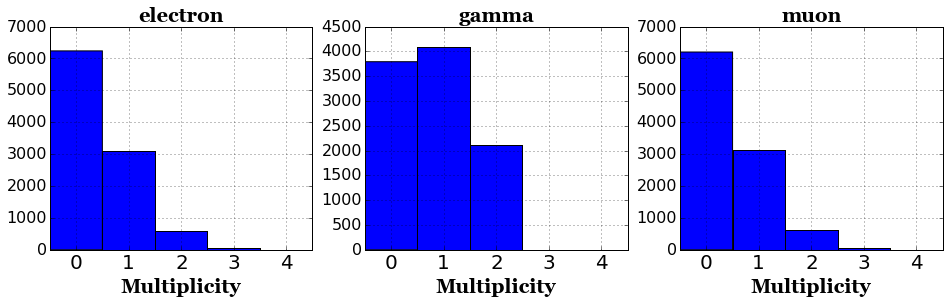

Event counts with at least 1 electron or muon: 6371
Event counts with at least 1 gamma ray: 6208


In [13]:
from matplotlib.ticker import FormatStrFormatter
# Compare electron vs. muon vs. gamma ray multiplicity distributions
fig, axes = plt.subplots(1,3,figsize=(16,4),facecolor='w')

for index, name in enumerate(['electron','gamma','muon']):
    ax = axes[index]
    exec('ax.hist(df.multi_{}, bins=5, range=(-0.5,4.5))'.format(name))
    ax.set_xlim(-0.5,4.5)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.xaxis.set_ticks(np.arange(0, 5, 1.))
    ax.set_title(name,fontsize=20,fontweight='bold',fontname='Georgia')
    ax.set_xlabel('Multiplicity',fontsize=20,fontweight='bold',fontname='Georgia')
    ax.tick_params('x',labelsize=20)
    ax.tick_params('y',labelsize=16)
    ax.grid()
plt.show()

print('Event counts with at least 1 electron or muon:',df.query('multi_electron >0 or multi_muon >0').index.size)
print('Event counts with at least 1 gamma ray:',df.query('multi_gamma>0').index.size)

Again, this seems to confirm our expectation. Finally, when we went over the [sample generation configuration](#overview), we predicted the mean number of track particles to be slightly higher than shower particles. 

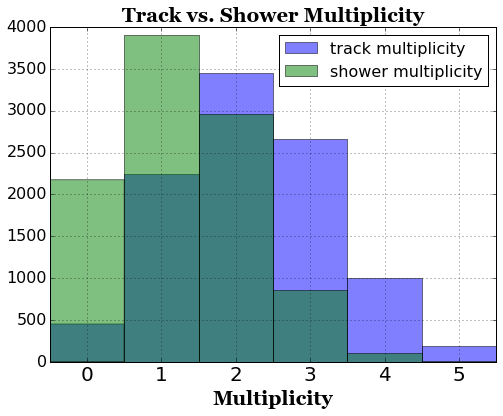

In [14]:
fig, ax = plt.subplots(figsize=(8,6),facecolor='w')

track_counts  = df.multi_muon.values + df.multi_piplus.values + df.multi_piminus.values + df.multi_proton.values
shower_counts = df.multi_electron.values + df.multi_gamma.values

ax.hist(track_counts,  bins=6, range=(-0.5,5.5), alpha=0.5, label='track multiplicity')
ax.hist(shower_counts, bins=6, range=(-0.5,5.5), alpha=0.5, label='shower multiplicity')

ax.set_xlim(-0.5,5.5)
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.xaxis.set_ticks(np.arange(0, 6, 1.))
ax.set_title("Track vs. Shower Multiplicity",fontsize=20,fontweight='bold',fontname='Georgia')
ax.set_xlabel('Multiplicity',fontsize=20,fontweight='bold',fontname='Georgia')
ax.tick_params('x',labelsize=20)
ax.tick_params('y',labelsize=16)
ax.grid()

leg=plt.legend(fontsize=16,loc=1)
leg_frame=leg.get_frame()
leg_frame.set_facecolor('white')

plt.show()

... which confirms our hypothesis. Next, let's check on particle energy distributions for fun. We stored "initial kinetic energy" and "deposit energy" sums. If generated particles give up all available energy in the image, then these two quantities should match. If a particle deposit energy outside, then deposit energy would be lower.

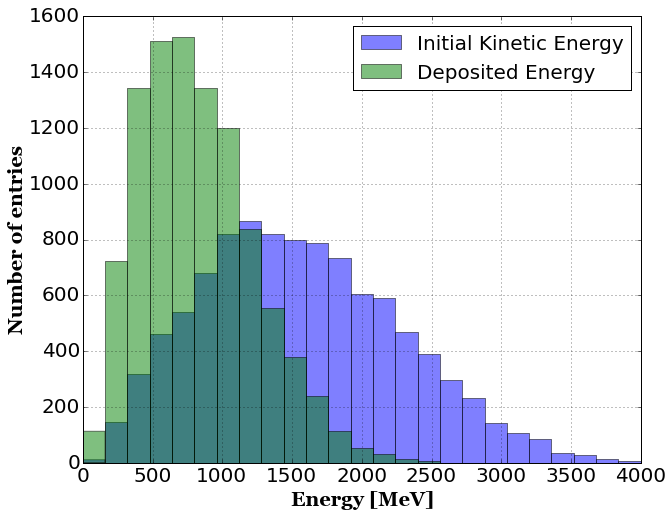

In [15]:
fig,ax = plt.subplots(figsize=(10,8),facecolor='w')
plt.hist(df.initial_energy.values,bins=25,range=(0.,4000),alpha=0.5,label="Initial Kinetic Energy")
plt.hist(df.deposit_energy.values,bins=25,range=(0.,4000),alpha=0.5,label="Deposited Energy")
plt.tick_params(labelsize=20)
plt.grid(True,which='both')
plt.xlabel('Energy [MeV]',fontsize=20,fontweight='bold',fontname='Georgia')
plt.ylabel('Number of entries',fontsize=20,fontweight='bold',fontname='Georgia')
leg=plt.legend(fontsize=20,loc=1)
leg_frame=leg.get_frame()
leg_frame.set_facecolor('white')
plt.show()

This shows we have a significant portion of energy escaped (i.e. not contributing in the recorded image). Is this OK?! It is OK :) Let's take an example of a muon which is generated in the range of 50 to 1000 MeV (see [sample generation overview](#overview) section). A [minimum-ionizing-particle (MIP)](https://en.wikipedia.org/wiki/Stopping_power_(particle_radiation)#Minimum_ionizing_particle) muon deposits $\approx2$ MeV/cm. Given our image size of 128 cm$^2$, that means a high energy muon, say 500 MeV$, won't fit in our image region. So this is somewhat expected.

To see this effect more clearly, maybe we can look at 3 categories of events:

1. Events with only shower particles (electron + gamma)
2. Events with only protons 
3. Events with only muon + pion tracks

We expect 3 to have the largest discrepancy between initial kinetic and deposit energy because both muon and pion can travel very far without stopping. We expect the best agreement in 2 because protons has very high stopping power (i.e. MeV/cm) and thus travel very short distance to deposit large amount of energy. We expect 1 to be somewhere in between: electromagnetic shower loses energy in a [different process](https://en.wikipedia.org/wiki/Particle_shower#Electromagnetic_showers) which also requires a large field of view. So some energy may not be recorded, but probably better than 3. 

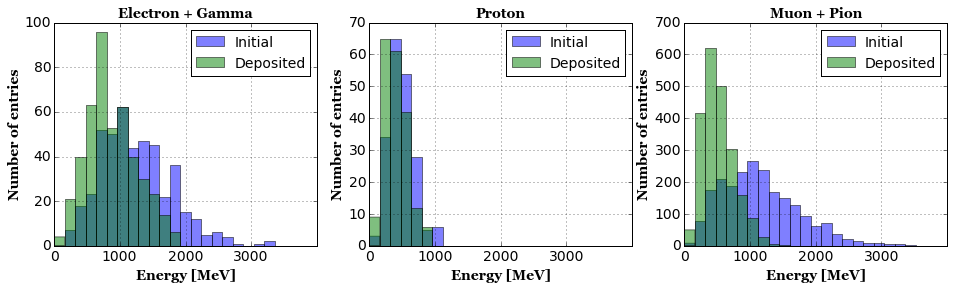

In [16]:
fig, axes = plt.subplots(1,3,figsize=(16,4),facecolor='w')

queries = ['multi_total == (multi_electron + multi_gamma)',
           'multi_total == (multi_proton)',
           'multi_total == (multi_muon + multi_piplus + multi_piminus + multi_proton)']
titles  = ['Electron + Gamma','Proton','Muon + Pion']

for index, query in enumerate(queries):

    sub_df=df.query(query)
    ax = axes[index]
    ax.hist(sub_df.initial_energy.values,bins=25,range=(0.,4000),alpha=0.5,label='Initial')
    ax.hist(sub_df.deposit_energy.values,bins=25,range=(0.,4000),alpha=0.5,label='Deposited')
    ax.set_title(titles[index],fontsize=14,fontweight='bold',fontname='Georgia')

    ax.tick_params(labelsize=14)
    ax.grid(True,which='both')
    ax.set_xlabel('Energy [MeV]',fontsize=14,fontweight='bold',fontname='Georgia')
    ax.set_ylabel('Number of entries',fontsize=14,fontweight='bold',fontname='Georgia')

    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.xaxis.set_ticks(np.arange(0, 4000, 1000.))
    
    leg=ax.legend(fontsize=14,loc=1)
    leg_frame=leg.get_frame()
    leg_frame.set_facecolor('white')

    
plt.show()

These are roughly what we would expect. So protons are _largely_ contained, and muon and pions have a fair chance of escaping. 

<a name="cluster"></a>
## Particle Instance-wise 2D Pixel Cluster
Here we come back to discuss about **cluster2d_mcst_tree** mentioned in the ["file contents"](#file_contents) section. This is a data product that stores a list of 2D pixels that belong to a particular particle stored in particle_mcst_tree. The stored 2D pixels also records the fraction of charge in the corresponding pixel of an image stored in image2d_data_tree. So you really get the _full_ information about individual particle instance. In this notebook I cover the basics of cluster2d data product and some useful example applications.

### Basics: cluster 2D and particle info
Let's start with the basics. How many particles do we have stored in particle_mcst_tree, and how many clusters stored in cluster2d_mcst_tree?

In [17]:
ENTRY = 2
# Create TChain
chain_particle  = TChain("particle_mcst_tree")
chain_cluster2d = TChain("cluster2d_mcst_tree")

for chain in [chain_particle, chain_cluster2d]:
    chain.AddFile('test_10k.root')
    chain.GetEntry(ENTRY)
    
cpp_particle  = chain_particle.particle_mcst_branch
cpp_cluster2d = chain_cluster2d.cluster2d_mcst_branch

# Print number of particles
print('Number of particles:',cpp_particle.as_vector().size())
# Print number of stored clusters in the first projection
print('Number of clusters:',cpp_cluster2d.cluster_pixel_2d(0).as_vector().size())
    

Number of particles: 4
Number of clusters: 5


Don't panic! Here's the reason why two numbers do not match. particle_mcst_tree stores particles that are tracked (i.e. their trajectories are simulated in the detector) but **not all of them**. In actuality the number of partickes tracked can become huge, sometimes more than 10,000, so we employ a certain criteria to record only useful ones with pretty low criteria thresholds to avoid missing information. cluster2d_mcst_tree stores all energy depositions per particle stored in particle_mcst_tree **plus** all energy depositions made by other particles (not stored in particle_mcst_tree) combined into 1 cluster. This is why the number of clusters stored in cluster2d_mcst_tree is **always 1 larger** than number of particles stored in particle_mcst_tree.

Let's look at a bit more:

In [18]:
for index, particle in enumerate(cpp_particle.as_vector()):
    cluster = cpp_cluster2d.cluster_pixel_2d(0).as_vector()[index]
    msg = 'Particle {:d} has TrackID {:d} and PDG {:d} with {:d} non-zero pixels!'
    print(msg.format(index,particle.track_id(),particle.pdg_code(),cluster.as_vector().size()))

Particle 0 has TrackID 1 and PDG 2212 with 89 non-zero pixels!
Particle 1 has TrackID 2 and PDG 2212 with 43 non-zero pixels!
Particle 2 has TrackID 3 and PDG 22 with 163 non-zero pixels!
Particle 3 has TrackID 4 and PDG 22 with 920 non-zero pixels!


My next natural question would be... **"Can we draw clusters?"** We sure can! Here, I use a handy function that converts cluster2d into image2d. 

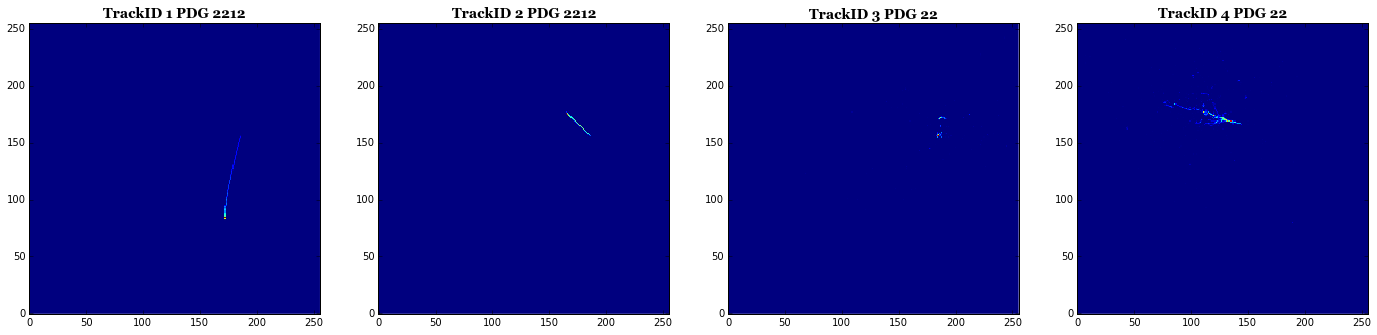

In [19]:
num_particles = cpp_particle.as_vector().size()

fig, axes = plt.subplots(1,num_particles,figsize=(24,8), facecolor='w')
for index, particle in enumerate(cpp_particle.as_vector()):
    ax = axes[index]
    title = 'TrackID {:d} PDG {:d}'.format(particle.track_id(),particle.pdg_code())
    # Draw image from cluster2d_mcst_tree (from projection 0)
    cluster2d = cpp_cluster2d.cluster_pixel_2d(0).as_vector()[index]
    image2d = larcv.as_image2d(cluster2d, cpp_cluster2d.cluster_pixel_2d(0).meta())
    image2d = larcv.as_ndarray(image2d) * 100.
    ax.imshow(image2d, interpolation='none', cmap='jet', origin='lower')
    ax.set_title(title,fontsize=14,fontname='Georgia',fontweight='bold')

plt.show()

You can see that I multiplied "100." scaling factor to each image so that it would look like what we visualized from image2d earlier (see [sample generation configuration](#overview)). We can even plot all clusters and compare with the corresponding image data from image2d_data_tree.

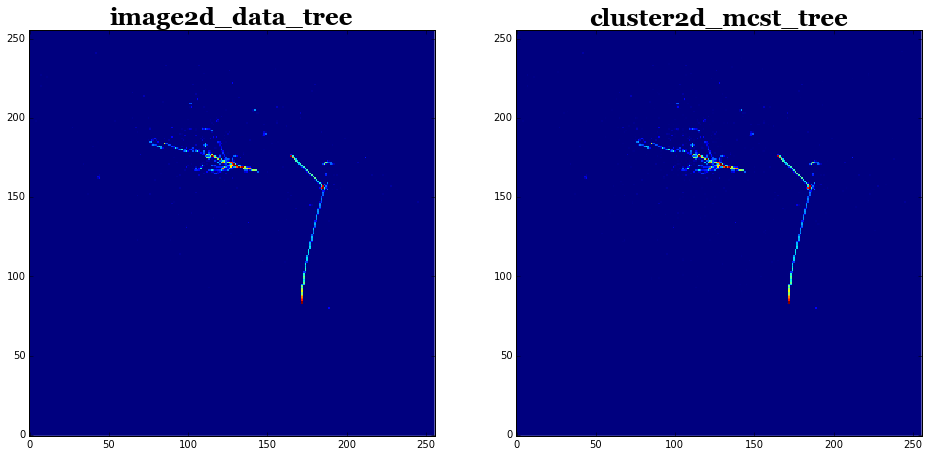

In [20]:
# Draw image2d
chain_image2d = TChain("image2d_data_tree")
chain_image2d.AddFile('test_10k.root')
chain_image2d.GetEntry(ENTRY)
cpp_image2d = chain_image2d.image2d_data_branch.as_vector().front()

fig, (ax0,ax1) = plt.subplots(1,2,figsize=(16,8), facecolor='w')

image2d = larcv.as_ndarray(cpp_image2d)
ax0.imshow(image2d, interpolation='none', cmap='jet', vmin=0, vmax=1000, origin='lower')
ax0.set_title('image2d_data_tree',fontsize=24,fontname='Georgia',fontweight='bold')

# Draw from cluster2d
cluster2d = np.zeros(image2d.shape,dtype=np.float32)

num_particles = cpp_particle.as_vector().size()
for index, particle in enumerate(cpp_particle.as_vector()):
    title = 'TrackID {:d} PDG {:d}'.format(particle.track_id(),particle.pdg_code())
    # Draw image from cluster2d_mcst_tree (from projection 0)
    particle_cluster = cpp_cluster2d.cluster_pixel_2d(0).as_vector()[index]
    image2d_from_cluster2d = larcv.as_image2d(particle_cluster, cpp_cluster2d.cluster_pixel_2d(0).meta())
    image2d_from_cluster2d = larcv.as_ndarray(image2d_from_cluster2d) * 100.
    cluster2d = cluster2d + image2d_from_cluster2d
    
ax1.imshow(cluster2d, interpolation='none', cmap='jet', vmin=0, vmax=1000, origin='lower')
ax1.set_title('cluster2d_mcst_tree',fontsize=24,fontname='Georgia',fontweight='bold')

plt.show()

As you can see, by combining clusters, we recovered image2d! But are they really identical? We can check some numpy array function returns.

In [21]:
msg = 'Image from {:s} ... mean {:.4g} pixel count {:d}'
print(msg.format('image2d_data_tree',image2d.mean(),(image2d>0).astype(np.int32).sum()))
print(msg.format('cluster2d_data_tree',cluster2d.mean(),(cluster2d>0).astype(np.int32).sum()))

Image from image2d_data_tree ... mean 1.936 pixel count 650
Image from cluster2d_data_tree ... mean 1.979 pixel count 1204


Wow, the mean is close but pixel count is _very much_ different! Why?! What we missed is to apply another condition described in [sample generation configuration](#overview) section: apply $\geq10$ pixel value threshold.

In [22]:
msg = 'Image from {:s} ... mean {:.4g} pixel count {:d}'
nonzero_image2d   = image2d[np.where(image2d>=10.)]
nonzero_cluster2d = cluster2d[np.where(cluster2d>=10.)]
print(msg.format('image2d_data_tree',nonzero_image2d.mean(),len(nonzero_image2d)))
print(msg.format('cluster2d_data_tree',nonzero_cluster2d.mean(),len(nonzero_cluster2d)))

Image from image2d_data_tree ... mean 195.2 pixel count 650
Image from cluster2d_data_tree ... mean 194.2 pixel count 657


which shows not exactly the same, but quite close. I am not quite sure the reason that causes this difference. But it is possible because **image2d is not derived from cluster2d** and they are created in 2 parallel processes in the production chain. I opened an [issue on github](https://github.com/DeepLearnPhysics/larcv2/issues/14) to look at this difference in the future release of larcv. Nevertheless, this does not change the usefulness of cluster2d!

Finally, with what I showed already, you are right to think about an image with particle instance-wise label.

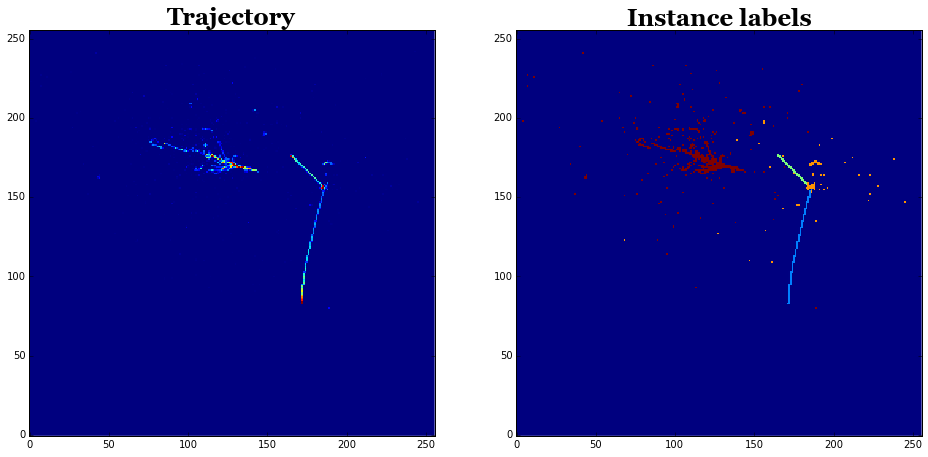

In [23]:
fig, (ax0,ax1) = plt.subplots(1,2,figsize=(16,8), facecolor='w')

ax0.imshow(cluster2d, interpolation='none', cmap='jet', vmin=0, vmax=1000, origin='lower')
ax0.set_title('Trajectory',fontsize=24,fontname='Georgia',fontweight='bold')

# Create instance-wise label
label_cluster2d = np.zeros(cluster2d.shape,dtype=np.float32)

num_particles = cpp_particle.as_vector().size()
for index, particle in enumerate(cpp_particle.as_vector()):
    title = 'TrackID {:d} PDG {:d}'.format(particle.track_id(),particle.pdg_code())
    # Draw image from cluster2d_mcst_tree (from projection 0)
    particle_cluster = cpp_cluster2d.cluster_pixel_2d(0).as_vector()[index]
    image2d_from_cluster2d = larcv.as_image2d(particle_cluster, cpp_cluster2d.cluster_pixel_2d(0).meta())
    image2d_from_cluster2d = larcv.as_ndarray(image2d_from_cluster2d) * 100.
    label_cluster2d[np.where(image2d_from_cluster2d >= 10.)] = index+1
    
ax1.imshow(label_cluster2d, interpolation='none', cmap='jet', vmin=0, vmax=num_particles, origin='lower')
ax1.set_title('Instance labels',fontsize=24,fontname='Georgia',fontweight='bold')
plt.show()

## Closing remark
In this notebook I swept the surface of the [segmentation challenge](http://deeplearnphysics.org/DataChallenge/#ChallengeSegmentation) public data set we added recently. The sample was primarily prepared for training an algorithm for [track/shower pixel segmentation](#semantic_segmentation). However it can be used for training an algorithm for object detection and/or instance-aware semantic segmentation. I hope you find this data set interesting. As usual, if you have feature requests for future versions of this data set, [contact us](mailto:contact@deeplearnphysics.org). If you find our software useful, please give stars to [our software](https://github.com/DeepLearnPhysics/larcv).